# Fit a Classification Model

**Step 1: Import Libraries**

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

**Step 2: Read in Data**

In [2]:
# READ IN DATA
raw_comma = pd.read_csv(
    'https://raw.githubusercontent.com/fivethirtyeight/data/master/comma-survey/comma-survey.csv',
    skiprows=1, 
    header=None)

raw_comma.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3292953864,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Not much,Somewhat important,Male,30-44,"$50,000 - $99,999",Bachelor degree,South Atlantic


**Step 3: Wrangle Data**

In [3]:
# SELECT AND RENAME COLUMNS
comma = (raw_comma
    .dropna(subset = [8])
    .drop([0,9,10,11,12], axis=1)
    .rename(columns = {
        1:'write_comma',
        2:'heard_comma',
        3:'care_comma',
        4:'write_data',
        5:'heard_data',
        6:'care_data',
        7:'care_grammar',
        8:'gender',
        }))

# RECODE VALUES FOR MODELING
def yn_recode(input):
    if input == "Yes": return 1
    elif input == "No": return -1
    else: return np.nan

def scale_recode(input):
    if input == "A lot" or input == "Very important" : return 2
    elif input == "Some" or input == "Somewhat important": return 1
    elif input == "Not much" or input == "Somewhat unimportant": return -1
    elif input == "Not at all" or input == "Very unimportant": return -2
    else: return np.nan

def write_comma_recode(input):
    if input == "It's important for a person to be honest, kind, and loyal.": return 1
    elif input == "It's important for a person to be honest, kind and loyal.": return -1
    else: return np.nan

def write_data_recode(input):
    if input == "Some experts say it's important to drink milk, but the data are inconclusive.": return 1
    elif input == "Some experts say it's important to drink milk, but the data is inconclusive.": return -1
    else: return np.nan

for i in ['care_comma','care_data','care_grammar']:
    comma[i] = comma[i].apply(scale_recode)

for i in ['heard_comma','heard_data']:
    comma[i] = comma[i].apply(yn_recode)

comma["write_comma"] = comma["write_comma"].apply(write_comma_recode)
comma["write_data"] = comma["write_data"].apply(write_data_recode)

# REMOVE NA'S
ml_comma = comma.dropna().reset_index(drop = True)

**Step 4: Model Data**

In [4]:
# SET FILTERED VARIABLES 
X_pred = ml_comma.drop(columns = ['gender'])
y_pred = ml_comma['gender'] == 'Male'

# SPLIT VARIABLES
X_train, X_test, y_train, y_test = train_test_split(X_pred,y_pred,test_size=.2,random_state = 1)

# CREATE FITTED MODEL WITH TRAINING DATA
clf = RandomForestClassifier(random_state=1).fit(X_train, y_train)

# TEST MODEL AND REPORT ACCURACY
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

**Step 5:  Model Metrics**

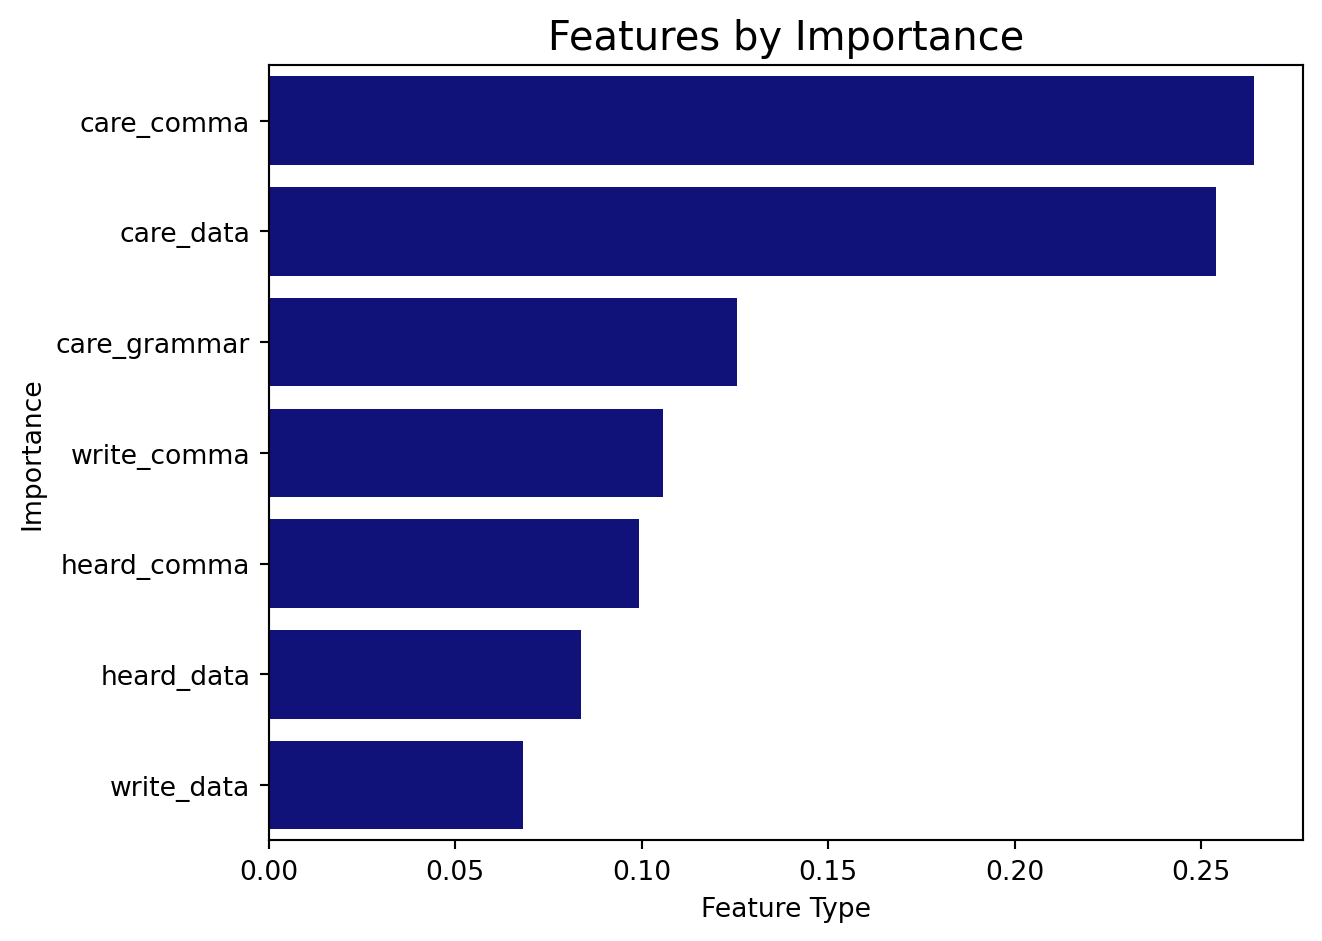

[[69 40]
 [43 50]]


C:\Users\Aj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


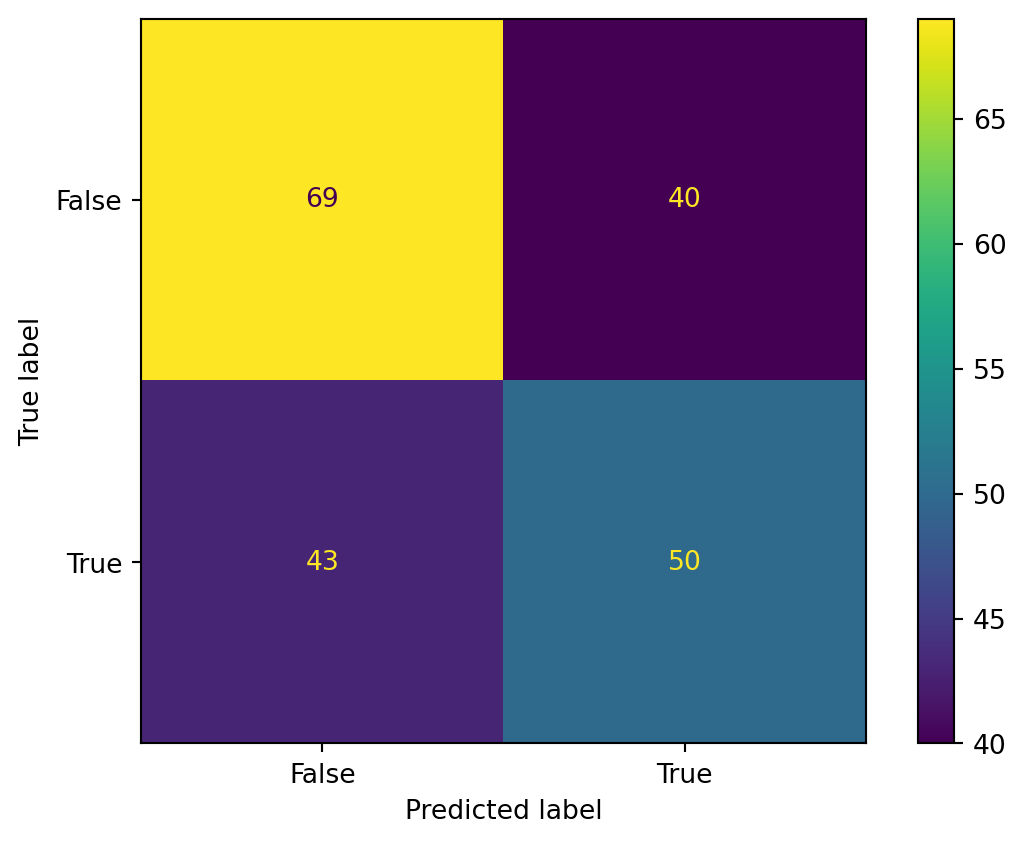

In [5]:
#| label: feature importance chart.

# GIVE FEATURE IMPORTANCE
feature_raw = pd.DataFrame(
    {'features': X_train.columns, 
    'importance': clf.feature_importances_})

feature_df = (feature_raw
    .sort_values(['importance'], ascending=False)
    .head(12)
    .reset_index(drop=True)
    )

#MAKE PLOT FOR MOST IMPORTANT FEATURES
f, ax = plt.subplots()
sns.barplot(x="importance", y="features", data=feature_df, color = 'darkblue')
ax.set_ylabel('Importance', fontsize = 10)
ax.set_xlabel('Feature Type', fontsize = 10)
ax.set_title('Features by Importance', fontsize = 15)
plt.tight_layout()
plt.show()

print(metrics.confusion_matrix(y_test, y_pred))
matrixpng_raw = metrics.plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# Describe Classification Models

## Confusion matrix array
The confusion matrix shows all the combinations of the following: 

- The prediction on a row of data
- The actual state of the row of data

There are four types of general labels from the confusion matrix:

- If the prediction is TRUE, and the classification is correct, then this is a **TRUE POSITIVE**. 

- If the prediction is TRUE, and the classification is not correct, then this is a **FALSE POSITIVE**.

- If the prediction is FALSE, and the classification is correct, then this is a **TRUE NEGATIVE**. 

- If the prediction is FALSE, and the classification is not correct, then this is a **FALSE NEGATIVE**.

The following array describes the confusion matrix values. The left and right columns describe whether or not the classification has been predicted TRUE or FALSE. The top and bottom rows describe the actual or true state of the data. 


In [6]:
#| code-fold: false
metrics.confusion_matrix(y_test, y_pred)
# queries first row, then column
TN = metrics.confusion_matrix(y_test, y_pred)[0][0] 
FP = metrics.confusion_matrix(y_test, y_pred)[0][1]
FN = metrics.confusion_matrix(y_test, y_pred)[1][0]
TP = metrics.confusion_matrix(y_test, y_pred)[1][1]

## Accuracy, Sensitivity, and Specificity
**Accuracy** describes *how many correct predictions* / *how many total predictions*. If the dataset is pretty even, this can be a very useful metric. This, however, may not be the case with all datasets. For example, if 95 percent of all data rows should be predicted negative, a model that *only* spits out negatives will be 95 percent accurate. 

There's a joke in machine learning: The professor says that he developed a model that predicts whether or not someone is a terrorist with over 99 percent accuracy. The students are perplexed and ask the professor to show them the model. The professor shows the following model: *f(x) = 0*. Since over 99 percent of people are NOT terrorists, just saying FALSE will be accurate over 99 percent of the time.

If we actually wanted to see how good this model is at identifying terrorists, we will need a different metric:


**Sensitivity** is like accuracy, but just for data that should be classified as positive. Sensitivity is calculated by *correctly predicted positives* / *all actual positives*. In the terrorist example, the numerator is how many terrorists were correctly identified, and the denominator is the total amount of terrorists. The sensitivity for the terrorist example would be zero percent because out of all terrorists, none of them were correctly identified.

**Specificity** is like accuracy, but just for data that should be classified as negative. Specificity is calculated by *correctly predicted negatives* / *all actual negatives*. In the terrorist example, the numerator is how many non-terrorists were correctly identified, and the denominator is the total amount of non-terrorists. The specificity for the terrorist example would be 100 percent since all non-terrorists were predicted to be non-terrorists.

**Accuracy for the Model**
The following code will calculate the accuracy for the model. The accuracy for the model is calculated by *correctly predicted rows* / *all rows*. More concretely, this is calculated by (*correctly predicted males* + *correctly predicted females*) / (*all males and females*)

In [7]:
#| code-fold: false
accuracy = (TN + TP) / (TN + TP + FN + FP)
print("Accuracy = ",(round(accuracy,2)*100),"%")

Accuracy =  59.0 %


**Sensitivity and Specificity for the Model**
The following code will calculate the sensitivity and specificity for the model. The sensitivity is calculated by *males predicted correctly* / *all males*. The specificity is calculated by *females predicted correctly* / *all females*. The reason why male is sensitivity and female is specificity is that in the code, male is coded in such a way that males are 1 (TRUE) and non-males (females) are 0 (FALSE). This is just for math.

In [8]:
#| code-fold: false
sensitivity = (TP) / (TP + FN)
specificity = (TN) / (TN + FP)

print("Sensitivity = ",(round(sensitivity,2)*100),"%")
print("Specificity = ",(round(specificity,2)*100),"%")

Sensitivity =  54.0 %
Specificity =  63.0 %
